In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
from sklearn.preprocessing import LabelEncoder,Imputer

In [98]:
df = pd.read_csv('./data/responses.csv')

In [99]:
df.head()

,Timestamp,Email Address,Name,Neighbourhood,Rating,Brands,Flavor,Packaging,Source,Type,Frequency,Price,Quality,Occasion,New_flavors
0,2/6/2018 19:12:51,NaN,Neha Baranwal,Thane,10,"Mother Dairy, Amul","Chocolate, Butterscotch",Cone,"Supermarkets, Ice cream parlour/ restaurants",Unit,Once a week,7.0,10.0,5,5.0
1,2/6/2018 19:17:21,NaN,Arvind Narayanan,Chembur,8,"Dinshaw’s, Amul, Kwality Walls","Chocolate, Vanilla, Butterscotch, Pistachio",Cone,"Ice cream parlour/ restaurants, Minimart",Unit,Once a month,7.0,8.0,10,4.0
2,2/6/2018 21:01:58,2015bhavika.adnani@ves.ac.in,Bhavika,Thane,8,"Baskin-Robbins, Amul, Kwality Walls","Chocolate, Vanilla, Coffee",Cone,"Ice cream parlour/ restaurants, Ice cream cart...",Unit,Once a month,1.0,10.0,8,6.0
3,2/6/2018 21:02:15,2015mayank.agrawal@ves.ac.in,Mayank Agrawal,Chembur,9,"Baskin-Robbins, Amul, Creambell","Chocolate, Butterscotch",Cone,Ice cream parlour/ restaurants,Unit,Once a month,2.0,10.0,9,4.0
4,2/6/2018 21:09:39,2015bhuvanesh.goplani@ves.ac.in,Bhuvanesh Goplani,Chembur,4,"Baskin-Robbins, Home made","Vanilla, Strawberry, Butterscotch",Tub,Ice cream parlour/ restaurants,Unit,Once a month,3.0,10.0,6,5.0


## Preprocessing

### Removing redundant columns

In [100]:
df.columns

Index(['Timestamp', 'Email Address', 'Name', 'Neighbourhood', 'Rating',
       'Brands', 'Flavor', 'Packaging', 'Source', 'Type', 'Frequency', 'Price',
       'Quality', 'Occasion', 'New_flavors'],
      dtype='object')

In [101]:
df = df.drop(['Timestamp', 'Email Address', 'Name', 'Type'], 1)

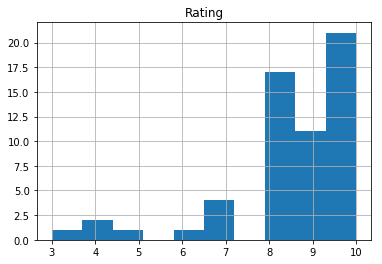

In [102]:
df.hist(column='Rating', bins=10)
plt.show()

### Dealing with null values

In [104]:
df.isnull().sum()

Neighbourhood    6
Rating           0
Brands           1
Flavor           0
Packaging        0
Source           1
Frequency        1
Price            1
Quality          2
Occasion         0
New_flavors      1
dtype: int64

In [105]:
def convStringToCat(df, column):
    nullCols = df[column].isnull()
    df[column].loc[nullCols] = 'NaN'
    df[column] = df[column].str.lower().str.strip()
    le = LabelEncoder()
    le.fit(df[column].values)
    df[column] = le.transform(df[column].values)
    df[column][nullCols] = np.nan
    return le

In [106]:
labelEncoders = {}
catColumns = ['Neighbourhood', 'Frequency', 'Packaging']
for catColumn in catColumns:
    labelEncoders[catColumn] = convStringToCat(df, catColumn)

/home/arvindo/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/arvindo/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [107]:
def removeMissingVals(col):
    imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
    df[col]=imp.fit_transform(df[[col]])

removeMissingVals("Neighbourhood")
removeMissingVals("Price")
removeMissingVals("Quality")
removeMissingVals("New_flavors")
removeMissingVals("Frequency")

df[['Neighbourhood','Price','Quality', 'New_flavors', 'Frequency']].isnull().sum()

Neighbourhood    0
Price            0
Quality          0
New_flavors      0
Frequency        0
dtype: int64

### Splitting multivalued attribues

In [108]:
def fetchOneHotColumns(df, column):
    type_columns = [type_.split(", ") if type(type_) != float else [] for type_ in df[column]]
    types = list(set(chain.from_iterable(type_columns)))
    typeDict = {}
    for type_ in types:
        typeDict[type_] = []
    for type_set in type_columns:
        for type_ in typeDict:
            if type_ in type_set:
                typeDict[type_].append(1)
            else:
                typeDict[type_].append(0)
    df_types = pd.DataFrame(typeDict)
    if 'any brand ' in df_types.columns:
        df_types = df_types.drop('any brand ', axis=1)
    return types, df_types

In [109]:
multivaluedCols = ['Brands', 'Flavor', 'Source']
multivaluedColDict = {}
for col in multivaluedCols:
    types, df_types = fetchOneHotColumns(df, col)
    multivaluedColDict[col] = types
    df = df.join(df_types).drop(col, axis=1)

In [110]:
df.isnull().sum()

Neighbourhood                     0
Rating                            0
Packaging                         0
Frequency                         0
Price                             0
Quality                           0
Occasion                          0
New_flavors                       0
Amul                              0
Baskin-Robbins                    0
Creambell                         0
Dinshaw’s                         0
Gelato Italiano                   0
Havmor                            0
Home made                         0
Kwality Walls                     0
Local Icecream shops              0
London Dairy                      0
Mother Dairy                      0
Naturals                          0
Vadilal                           0
patanjali icecreame               0
Butterscotch                      0
Chocolate                         0
Coffee                            0
Custard apple                     0
Mango                             0
Mint                        

### Label encoding and one hot encoding

## Visualization

### Location wise distribution of flavors and brands

In [111]:
brands = ['Amul', 'Baskin-Robbins', 'Creambell',
       'Dinshaw’s', 'Gelato Italiano ', 'Havmor', 'Home made', 'Kwality Walls',
       'Local Icecream shops', 'London Dairy', 'Mother Dairy', 'Naturals',
       'Vadilal', 'patanjali icecreame']

In [112]:
neighCount = {}
for Neighbourhood in df['Neighbourhood'].unique():
    neighString = labelEncoders['Neighbourhood'].inverse_transform([int(Neighbourhood)])[0]
    neighCount[labelEncoders['Neighbourhood'].inverse_transform([int(Neighbourhood)])[0]] = [len(df[(df['Neighbourhood'] == Neighbourhood) & (df[brand] == 1)]) for brand in brands]

/home/arvindo/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/arvindo/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/arvindo/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/arvindo/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

/home/arvindo/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [113]:
neighCount

{'asangaon': [1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0],
 'california': [1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1],
 'chembur': [15, 16, 3, 8, 0, 4, 1, 8, 1, 2, 6, 1, 5, 0],
 'dadar': [1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0],
 'dombivli': [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 'ghatkopar': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'govandi': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'kalyan': [2, 1, 0, 1, 0, 2, 0, 2, 0, 0, 0, 0, 1, 0],
 'kanjurmarg': [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0],
 'kurla': [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
 'lower parel': [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 'nerul': [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0],
 'panvel': [1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0],
 'thane': [10, 4, 1, 3, 1, 4, 0, 5, 0, 0, 3, 0, 2, 0],
 'ulhasnagar': [7, 5, 2, 2, 0, 1, 0, 7, 0, 0, 4, 0, 2, 0],
 'vikholri,mumbai': [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
 'vile parle': [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]}

### Area wise dominating factor

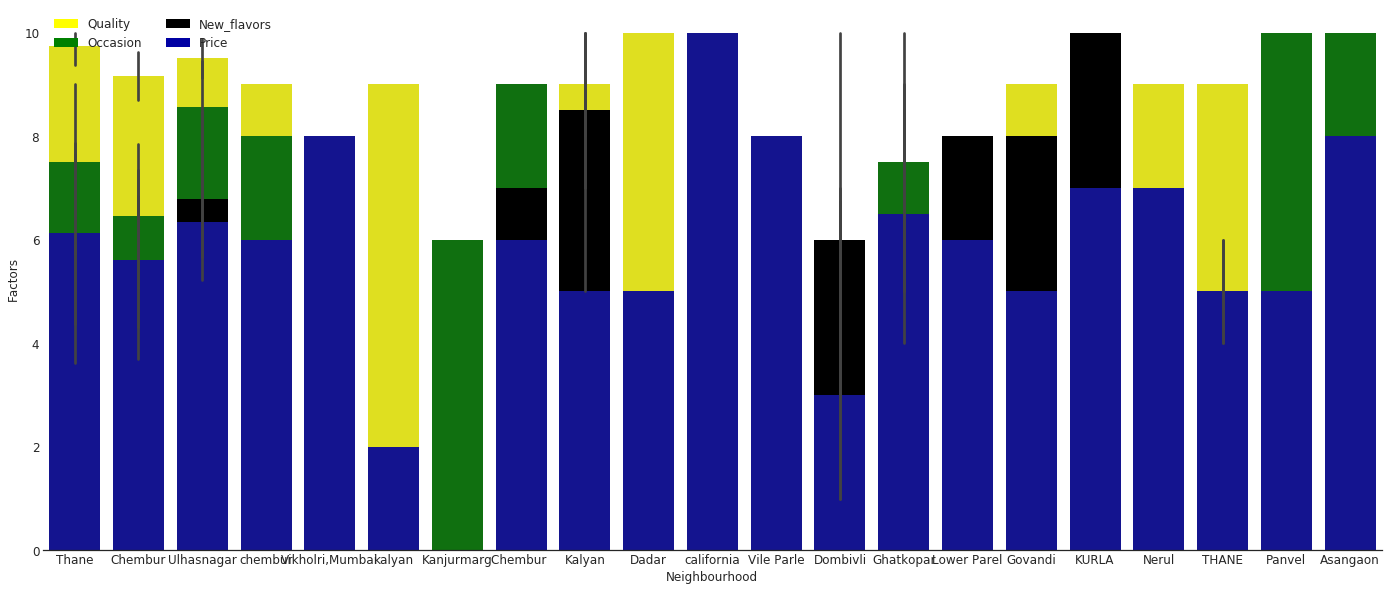

In [114]:
stacked_bar_data = pd.read_csv("./data/responses.csv")
stacked_bar_data["total"] = (stacked_bar_data.Price + stacked_bar_data.Quality + stacked_bar_data.Occasion + stacked_bar_data.New_flavors)/4
sns.set_style("white")
sns.set_context({"figure.figsize": (24, 10)})
sns.barplot(x = stacked_bar_data.Neighbourhood, y = stacked_bar_data.total, color = "red")
top_plot = sns.barplot(x = stacked_bar_data.Neighbourhood, y = stacked_bar_data.Quality, color = "yellow")
top_plot = sns.barplot(x = stacked_bar_data.Neighbourhood, y = stacked_bar_data.Occasion, color = "green")
top_plot = sns.barplot(x = stacked_bar_data.Neighbourhood, y = stacked_bar_data.New_flavors, color = "black")
bottom_plot = sns.barplot(x = stacked_bar_data.Neighbourhood, y = stacked_bar_data.Price, color = "#0000A3")
sns.despine(left=True)
bottom_plot.set_ylabel("Factors")
bottom_plot.set_xlabel("Neighbourhood")

#Set fonts to consistent 16pt size
for item in ([bottom_plot.xaxis.label, bottom_plot.yaxis.label] +
             bottom_plot.get_xticklabels() + bottom_plot.get_yticklabels()):
    item.set_fontsize(12)
    
Quality = plt.Rectangle((0,0),1,1,fc='yellow',  edgecolor = 'none')
Occasion = plt.Rectangle((0,0),1,1,fc='green',  edgecolor = 'none')
New_flavors = plt.Rectangle((0,0),1,1,fc='black',  edgecolor = 'none')
Price = plt.Rectangle((0,0),1,1,fc='#0000A3',  edgecolor = 'none')
l = plt.legend([Quality,Occasion,New_flavors,Price], ['Quality','Occasion','New_flavors','Price'], loc=2, ncol = 2, prop={'size':12})
l.draw_frame(False)

### Brand vs like-scale mapping

### Source vs Location

### Brand vs Flavor

### Rating vs (Price, Quality, Occasion and new flavors)



Text(0,0.5,'Price')

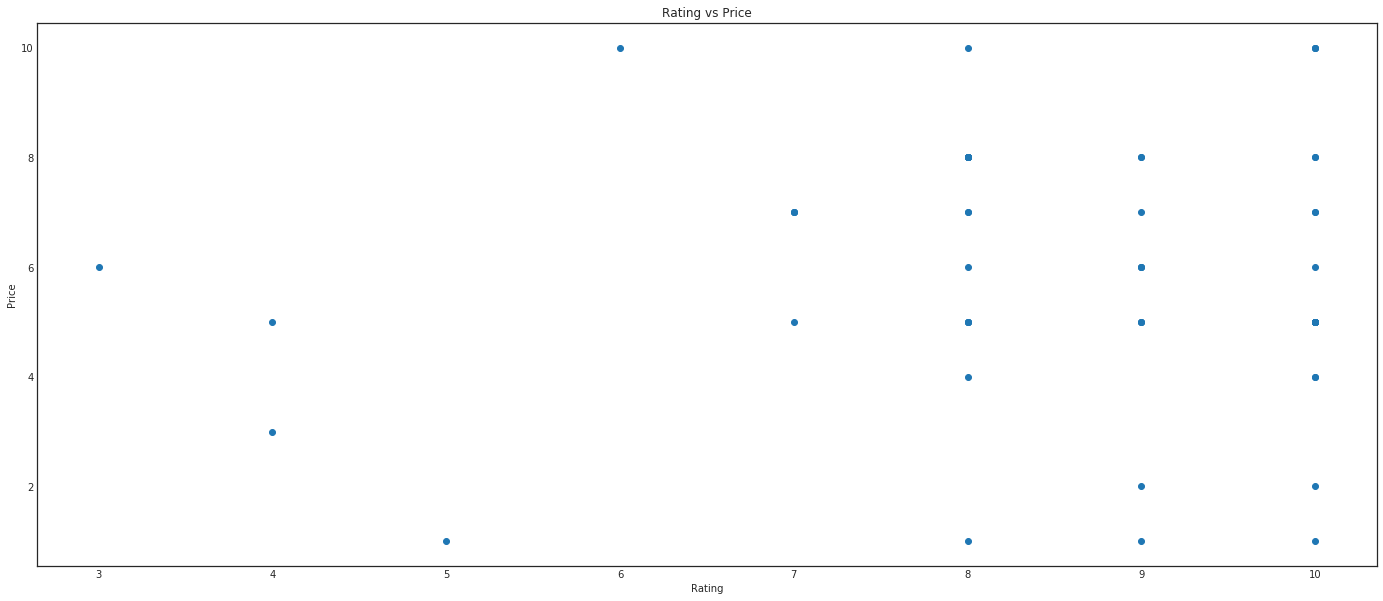

In [115]:
x=df.Rating.values
y=df.Price.values
plt.scatter(x,y)
plt.title("Rating vs Price")
plt.xlabel("Rating")
plt.ylabel("Price")

Text(0,0.5,'Quality')

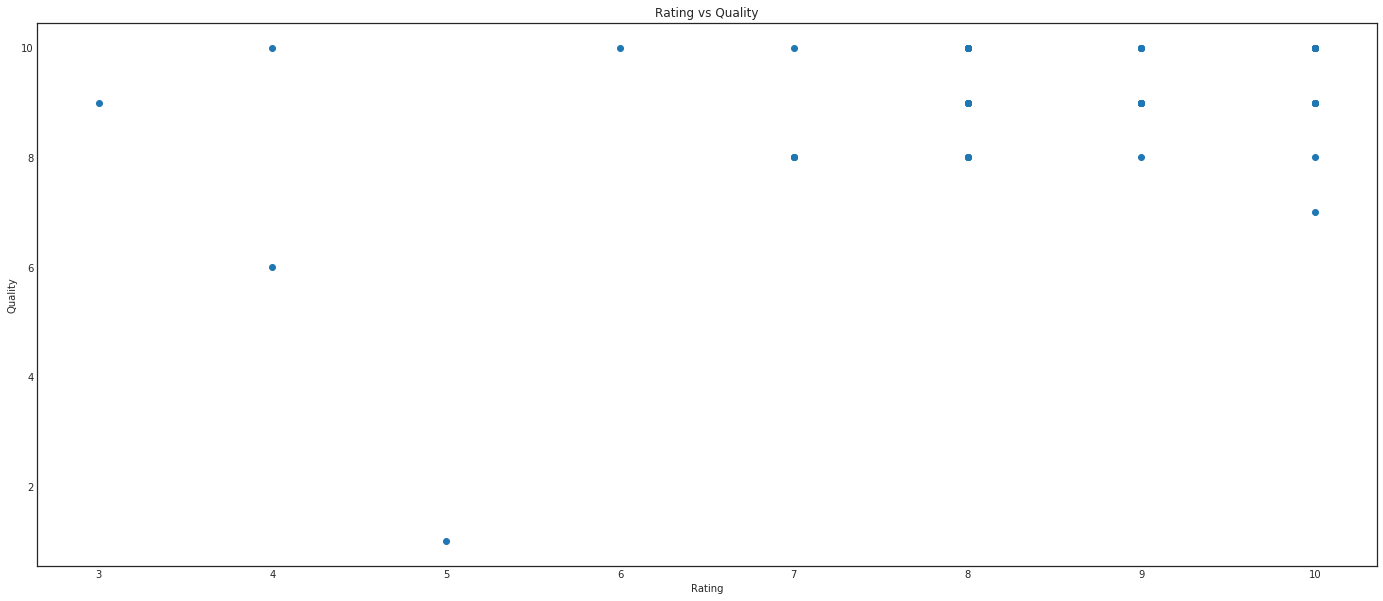

In [116]:
x=df.Rating.values
y=df.Quality.values
plt.scatter(x,y)
plt.title("Rating vs Quality")
plt.xlabel("Rating")
plt.ylabel("Quality")

Text(0,0.5,'Ocassion')

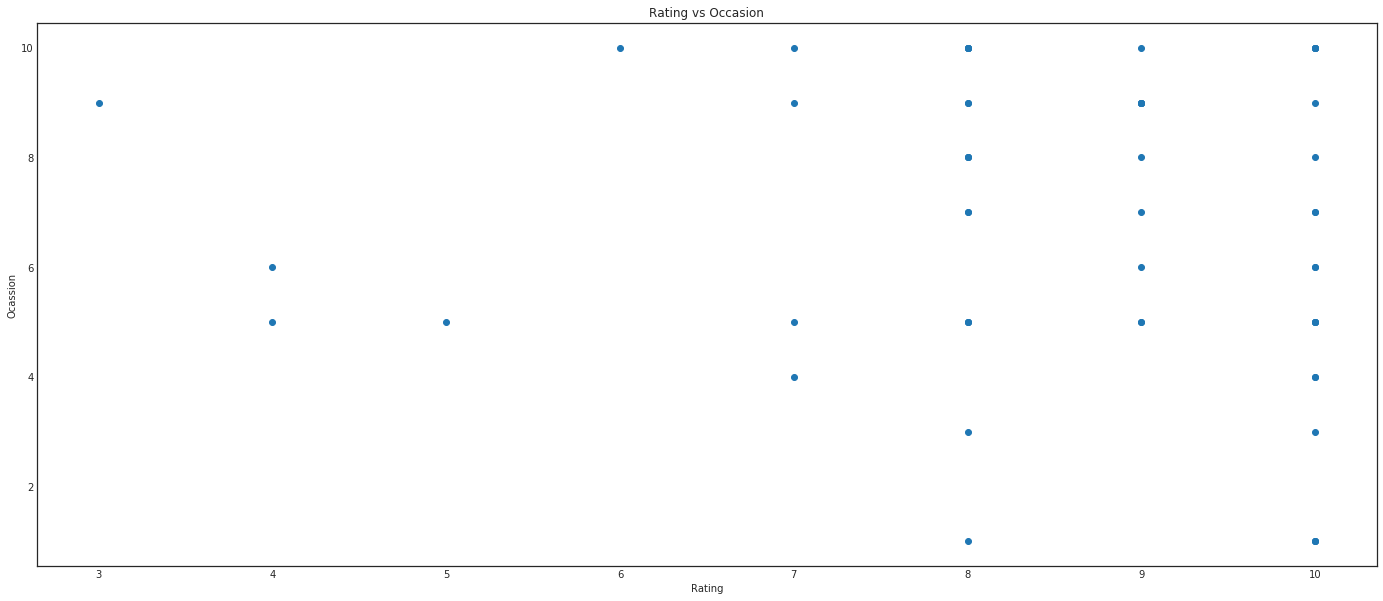

In [117]:
x=df.Rating.values
y=df.Occasion.values
plt.scatter(x,y)
plt.title("Rating vs Occasion")
plt.xlabel("Rating")
plt.ylabel("Ocassion")

Text(0,0.5,'Flavors')

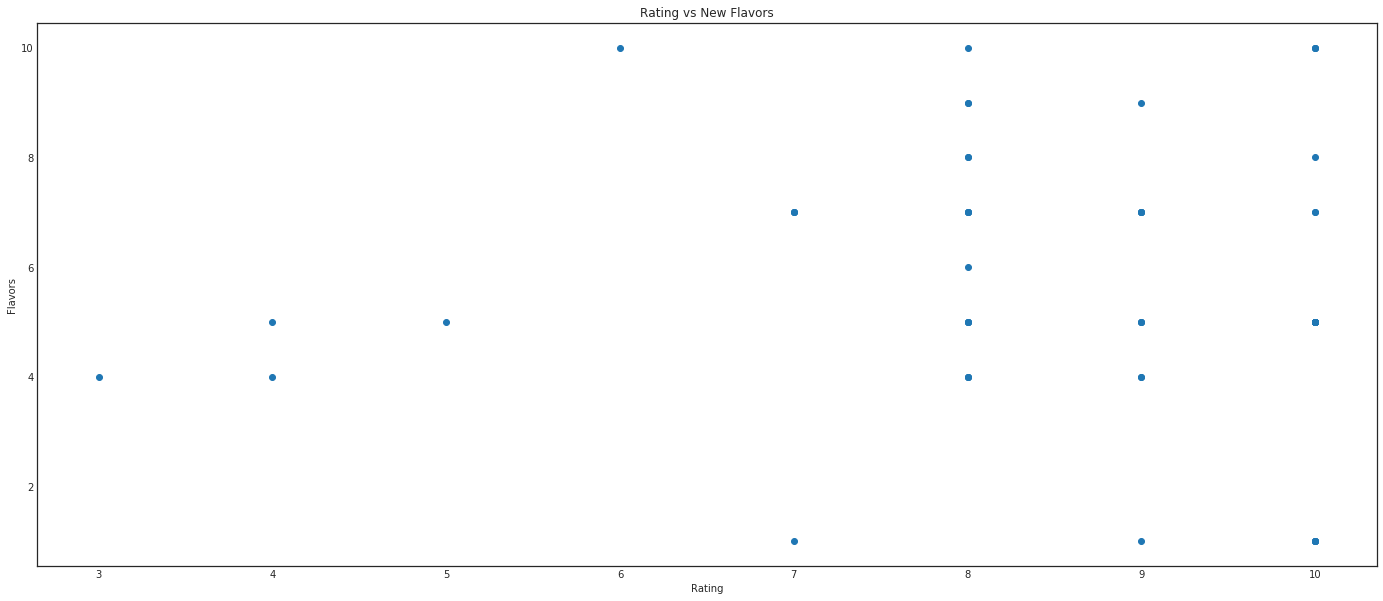

In [118]:
x=df.Rating.values
y=df.New_flavors.values
plt.scatter(x,y)
plt.title("Rating vs New Flavors")
plt.xlabel("Rating")
plt.ylabel("Flavors")

## Prediction

In [119]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
df.Rating.values
df_Y = df.Rating.values
df_X = df.drop(['Rating'],axis=1).values

# Split the data into training/testing sets
df_X_train = df_X[:40,:]
df_X_test = df_X[40:,:]

# Split the targets into training/testing sets
df_y_train = df_Y[:40]
df_y_test = df_Y[40:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(df_X_train, df_y_train)

# Make predictions using the testing set
df_y_pred = regr.predict(df_X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(df_y_test, df_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(df_y_test, df_y_pred))



Coefficients: 
 [-2.59195853e-02  1.14932909e+00  7.45690575e-01  1.83671125e-01
  6.36827089e-01 -3.91684432e-01  7.52784791e-03  3.47957676e+00
  7.81746007e-01  2.65018882e-01 -1.49450125e+00  2.80303935e+00
  5.13782014e-01 -3.92669979e+00  1.67206757e-01 -1.98098835e+00
  4.07505061e+00 -7.39829564e-01 -1.14033962e+00  9.65213472e-01
 -4.03121093e-01  1.31850372e+00  3.37148238e-01  6.35343954e-01
 -1.44691982e+00  4.07505061e+00 -1.46972004e+00  4.44089210e-15
  1.05212815e-01 -1.40503412e+00 -2.48841029e-02 -1.44691982e+00
 -4.03121093e-01  1.37809903e-01  1.08637784e+00 -8.17751599e-03
 -5.79522653e-02  2.31912460e+00 -2.24437169e-01]
Mean squared error: 11.13
Variance score: -4.82


In [120]:
df_y_pred

array([ 9.78596242, 12.98720295,  9.82172577,  7.52853569, 17.69714015,
       10.01922005, 10.44832698,  7.71784984,  4.03905903, 15.80073846,
        7.96495352, -0.19166288, 13.0200239 , 10.88729112,  7.89989271,
        9.00941022,  6.53681518,  8.78432582])